# Image Segmentation using *UNet*

- This is a tutorial on image segmentation for bioimages(i.e. fluorescence microscopy data) using UNet

## 1. Importing Modules & Packages

In [1]:
# Libraries for handlingg URL and file operations
import urllib                     # Library for handling URL operations
import os                         # Library for interacting with the operating system
import zipfile                    # Library for handling zip file operations

# Libraries for numerical and scientific computation
import numpy as np                # NumPy: manipulation of numerical arrays
import scipy.ndimage as ndi       # The image processing package scipy.ndimage
from scipy.ndimage import gaussian_filter  # Gaussian filter function from scipy.ndimage
from math import log10            # Math library for logarithmic calculations
import random                     # Library for random number generation

# Libraries for data visualization and plotting
import matplotlib.pyplot as plt   # The plotting module matplotlib.pyplot as plt
import seaborn as sns             # Seaborn: data visualization library
import pandas as pd               # Pandas: data manipulation and analysis library
import time                       # Time library for measuring execution time

# Libraries for image processing and handling
from PIL import Image             # Pillow: image processing library
from skimage import io            # Scikit-image: image I/O
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split


from albumentations import (
    Compose, Resize, HorizontalFlip, VerticalFlip, Rotate, Normalize
)
from albumentations.pytorch import ToTensorV2

# Libraries for machine learning and neural networks
import torch                      # PyTorch: deep learning library
import torch.nn as nn             # PyTorch neural network module
import torch.optim as optim       # PyTorch optimization module
from torch.utils.data import DataLoader, Dataset, random_split  # DataLoader and Dataset modules from PyTorch
from torchvision import transforms  # Transforms module from torchvision for image transformations
from torchsummary import summary    # Summary module from torchsummary for model summary

In [2]:
#sjdaivdiuvsndivnslvinfvfosidnfosdfnioin

In [3]:
# Set matplotlib backend
%matplotlib inline
#%matplotlib inline              # Displays as static figure in code cell output
#%matplotlib notebook            # Displays as interactive figure in code cell output
#%matplotlib qt                  # Displays as interactive figure in a separate window

In [4]:
# Check GPU
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
# Allocate memory on the GPU dynamically
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'    # Allow GPU memory to grow as needed

True
Tesla T4


In [5]:
# Set seeds for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# DataLoader setup
def worker_init_fn(worker_id):
    np.random.seed(42 + worker_id)
    random.seed(42 + worker_id)


# Set seeds for reproducibility
set_seed(42)

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



## 2. Importing and save data

In [7]:
# check if data has been downloaded already
zipPath = "/content/drive/Othercomputers/My Laptop/maestria/hackaton/epicV/challenge/small_data.zip"
extractPath = "/content/data0"  # Destination folder

with zipfile.ZipFile(zipPath, 'r') as zip_ref:
    zip_ref.extractall(extractPath)

print(f"Data extracted to {extractPath}")

Data extracted to /content/data0


In [8]:
from PIL import Image
import os

def extraer_frames_tiff(ruta_archivo_tiff, directorio_salida):
    """
    Extrae los fotogramas de un archivo TIFF y los guarda en un directorio.

    Args:
        ruta_archivo_tiff (str): La ruta al archivo TIFF.
        directorio_salida (str): La ruta al directorio donde se guardarán los fotogramas.
    """
    try:
        # Abre el archivo TIFF
        imagen = Image.open(ruta_archivo_tiff)

        # Crea el directorio de salida si no existe
        if not os.path.exists(directorio_salida):
            os.makedirs(directorio_salida)

        # Itera sobre los fotogramas
        for i in range(imagen.n_frames):
            # Selecciona el fotograma actual
            imagen.seek(i)

            # Genera el nombre del archivo de salida
            nombre_file = os.path.splitext(os.path.basename(ruta_archivo_tiff))[0]
            nombre_archivo = os.path.join(directorio_salida, f"{ruta_archivo_tiff}_{i+1}.png")

            # Guarda el fotograma como un archivo PNG (o el formato que desees)
            imagen.save(nombre_archivo, "PNG")

        print(f"Se extrajeron {imagen.n_frames} fotogramas de {ruta_archivo_tiff} y se guardaron en {directorio_salida}")

    except FileNotFoundError:
        print(f"Error: El archivo {ruta_archivo_tiff} no se encontró.")
    except Exception as e:
        print(f"Ocurrió un error: {e}")

# Ejemplo de uso:
ruta_del_tiff = "mi_imagen.tiff"  # Reemplaza con la ruta de tu archivo TIFF
directorio_de_salida = "frames_tiff" # Reemplaza con la ruta de tu directorio de salida

extraer_frames_tiff(ruta_del_tiff, directorio_de_salida)

Error: El archivo mi_imagen.tiff no se encontró.


## 3. Ploting image example from the training set

In [9]:
# Function to plot pairs of images

def pltPair(img1, img2, title1, title2, cmap1, cmap2, lim, fig_size):
    """This function displays a pair of input image with interpolation='none',in the range of lims. """

    plt.figure(figsize=(fig_size,fig_size))
    plt.subplot(1,2,1)
    plt.imshow(img1, interpolation='none', cmap=cmap1, vmin=lim[0], vmax=lim[1])
    plt.title(title1)
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.subplot(1,2,2)
    plt.imshow(img2, interpolation='none', cmap=cmap2, vmin=lim[2], vmax=lim[3])
    plt.title(title2)
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.show()



## 4. Image Segmentation using UNet


### Load images

In [10]:
# Custom dataset for loading images
class SegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        """
        Custom Dataset for segmentation.

        Args:
            image_paths (list): List of paths to input images.
            mask_paths (list): List of paths to masks.
            transform (callable, optional): Transform to apply.
        """
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = io.imread(self.image_paths[idx]).astype(np.float32)
        mask = io.imread(self.mask_paths[idx]).astype(np.float32)

        # Normalize images to [0, 1] and Convert mask to binary if needed
        image = (image - image.min()) / (image.max() - image.min() + 1e-8)
        mask = (mask > 0).astype(np.uint8)

        # Convert to PIL for transforms
        image = Image.fromarray(image)
        mask = Image.fromarray(mask)

        if self.transform:
            image, mask = self.transform(image, mask)

        return image, mask


In [11]:
class AlbumentationsTransform:
    def __init__(self, image_size=(128, 128), augment=False):
        if augment:
            self.transform = Compose([
                Resize(image_size[0], image_size[1]),
                HorizontalFlip(p=0.5),
                VerticalFlip(p=0.5),
                #Rotate(limit=180, p=0.5),  #rotation
                #Normalize(mean=(0.0,), std=(1.0,)),  # normalize to [0,1]
                ToTensorV2()
            ])
        else:
            self.transform = Compose([
                Resize(image_size[0], image_size[1]),
                #Normalize(mean=(0.0,), std=(1.0,)),
                ToTensorV2()
            ])

    def __call__(self, image, mask):
        # Albumentations expects numpy arrays
        image = np.array(image)
        mask = np.array(mask)

        # Apply transform
        augmented = self.transform(image=image, mask=mask)
        image = augmented["image"]
        mask = augmented["mask"].float().unsqueeze(0)  # shape [1, H, W]

        return image, mask


In [12]:
train_images_dir = '/content/data0/zfish/training/images/'
train_masks_dir = '/content/data0/zfish/training/masks/'
test_images_dir = '/content/data0/zfish/test/images/'
test_masks_dir = '/content/data0/zfish/test/masks/'



# Collect file paths
image_files = sorted([os.path.join(train_images_dir, f) for f in os.listdir(train_images_dir)])
mask_files = sorted([os.path.join(train_masks_dir, f) for f in os.listdir(train_masks_dir)])

# Split into train and validation
train_img_paths, val_img_paths, train_mask_paths, val_mask_paths = train_test_split(
    image_files, mask_files, test_size=0.2, random_state=42
)

# Test set paths
test_img_paths = sorted([os.path.join(test_images_dir, f) for f in os.listdir(test_images_dir)])
test_mask_paths = sorted([os.path.join(test_masks_dir, f) for f in os.listdir(test_masks_dir)])


In [13]:
# Custom dataset for loading images
# Image size and batch settings
image_size = (128, 128)
batch_size = 32

train_transform = AlbumentationsTransform(image_size=image_size, augment=True)  # Augmentations ON
val_test_transform = AlbumentationsTransform(image_size=image_size, augment=False)  # Augmentations OFF


# Create Datasets & Loaders

train_dataset = SegmentationDataset(train_img_paths, train_mask_paths, transform=train_transform)
val_dataset = SegmentationDataset(val_img_paths, val_mask_paths, transform=val_test_transform)
test_dataset = SegmentationDataset(test_img_paths, test_mask_paths, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


print(f"Train samples: {len(train_dataset)}, batches: {len(train_loader)}")
print(f"Validation samples: {len(val_dataset)}, batches: {len(val_loader)}")
print(f"Test samples: {len(test_dataset)}, batches: {len(test_loader)}")

Train samples: 720, batches: 23
Validation samples: 180, batches: 6
Test samples: 450, batches: 15


## Plot some images as examples

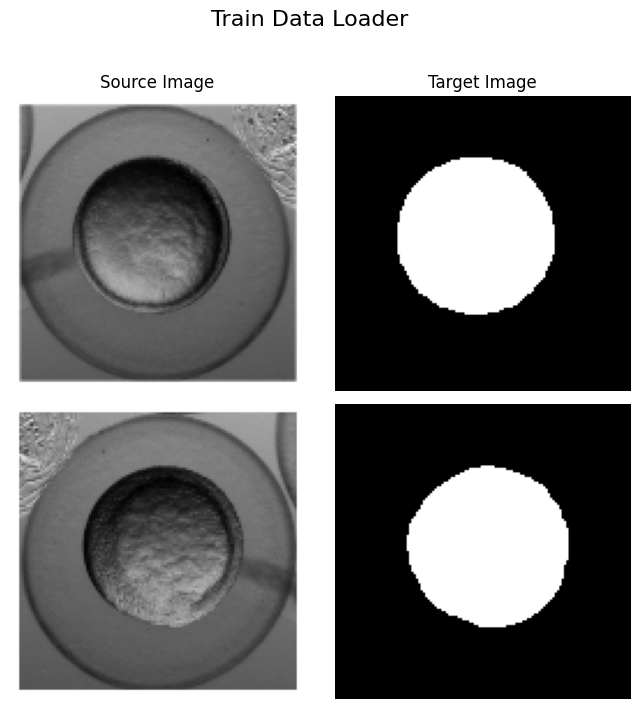

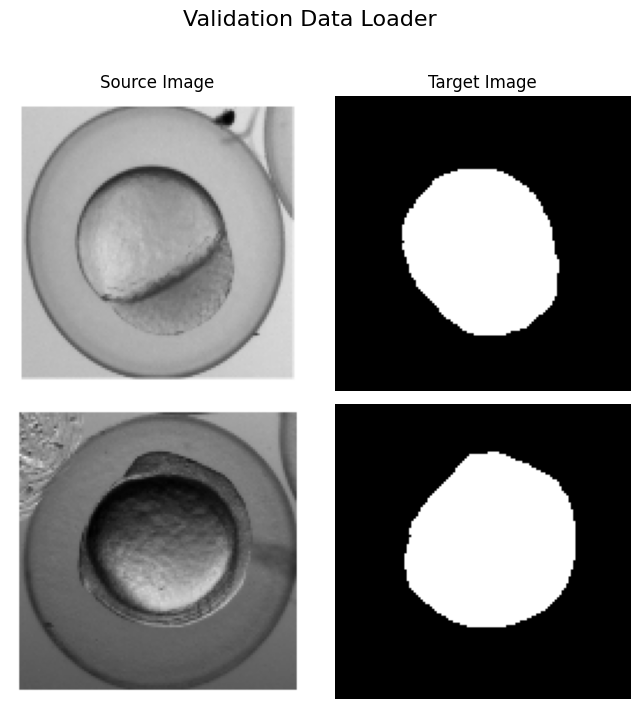

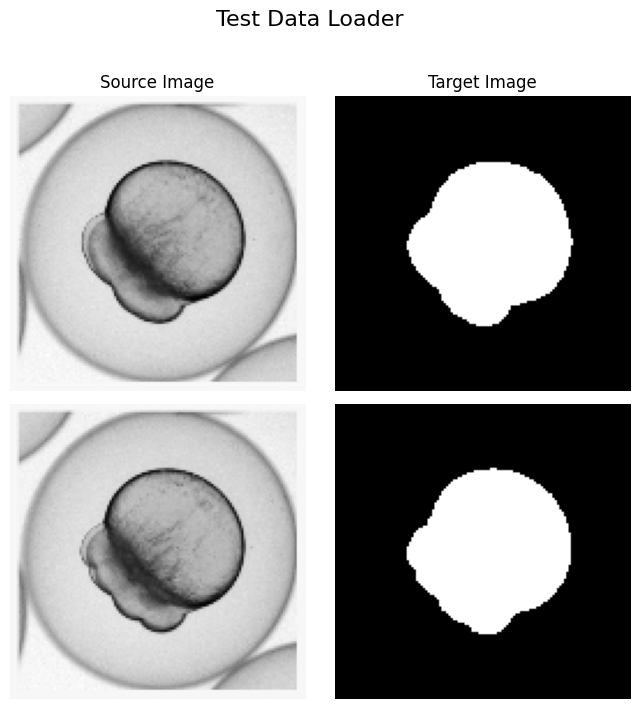

In [14]:
# Function to plot image pairs
def plot_image_pairs(data_loader, title, Nimages):
    data_iter = iter(data_loader)
    fig, axes = plt.subplots(nrows=Nimages, ncols=2, figsize=(8, 4*Nimages))
    fig.suptitle(title, fontsize=16)
    fig.subplots_adjust(wspace=0.1, hspace=0) # Adjust the spacing between subplots
    noisy_images, masks = next(data_iter) # get N pairs of images, N = batchc size

    # Plot fewer image pairs than the batch size
    if Nimages > noisy_images.shape[0]:
        Nimages = noisy_images.shape[0]

    for i in range(Nimages):
      axes[i, 0].imshow(np.squeeze(noisy_images[i]),cmap='gray')
      axes[i, 0].axis('off')
      axes[i, 1].imshow(np.squeeze(masks[i]),cmap='gray')
      axes[i, 1].axis('off')
      if i == 0:
          axes[i, 0].set_title('Source Image', fontsize=12)
          axes[i, 1].set_title('Target Image', fontsize=12)
    plt.show()

# Plotting train and test image pairs
plot_image_pairs(train_loader, "Train Data Loader", 2)
plot_image_pairs(val_loader, "Validation Data Loader", 2)
plot_image_pairs(test_loader, "Test Data Loader", 2)

## Define UNet model

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm


class ConvNeXtSegmentation(nn.Module):
    def __init__(self):
        super().__init__()

        # Load full ConvNeXt model (not features_only!)
        base_model = timm.create_model("convnext_tiny", pretrained=True)

        # Replace stem to accept grayscale input
        self.stem = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=4, stride=4),  # Original was Conv2d(3, 96, ...)
            nn.LayerNorm([96, 32, 32], eps=1e-6, elementwise_affine=True)
        )

        # Use the stages from the original model
        self.stages = nn.Sequential(
            base_model.stages[0],  # Down to 32x32
            base_model.stages[1],  # Down to 16x16
            base_model.stages[2],  # Down to 8x8
            base_model.stages[3],  # Down to 4x4
        )

        # Segmentation head to upsample and predict 1-channel mask
        self.seg_head = nn.Sequential(
            nn.Conv2d(768, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 1, kernel_size=1)
        )

    def forward(self, x):
        x = self.stem(x)        # (B, 96, 32, 32)
        x = self.stages(x)      # (B, 768, 4, 4)
        x = F.interpolate(x, size=(128, 128), mode='bilinear', align_corners=False)
        x = self.seg_head(x)
        return torch.sigmoid(x)


In [16]:
model = ConvNeXtSegmentation().cuda()

# Check summary
from torchsummary import summary
summary(model, (1, 128, 128))


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 32, 32]           1,632
         LayerNorm-2           [-1, 96, 32, 32]         196,608
          Identity-3           [-1, 96, 32, 32]               0
            Conv2d-4           [-1, 96, 32, 32]           4,800
         LayerNorm-5           [-1, 32, 32, 96]             192
            Linear-6          [-1, 32, 32, 384]          37,248
              GELU-7          [-1, 32, 32, 384]               0
           Dropout-8          [-1, 32, 32, 384]               0
          Identity-9          [-1, 32, 32, 384]               0
           Linear-10           [-1, 32, 32, 96]          36,960
          Dropout-11           [-1, 32, 32, 96]               0
              Mlp-12           [-1, 32, 32, 96]               0
         Identity-13           [-1, 96, 32, 32]               0
         Identity-14           [-1, 96,

## Train Model

In [ ]:
from torch.nn import TransformerEncoder, TransformerEncoderLayer

# Training parameters
num_epochs = 100
learning_rate = 0.0001
criterion = nn.BCELoss()    # Binary Cross Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
patience = 5  # Early stopping patience


# Store losses
train_losses = []
val_losses = []
best_val_loss = float('inf')
patience_counter = 0

# Training loop
for epoch in range(num_epochs):
    start_time = time.time()  # Start time for epoch
    model.train()
    train_loss = 0.0
    for images, masks in train_loader:

        images = images.cuda()
        masks = masks.cuda()
        outputs = model(images)
        loss = criterion(outputs, masks.float())

        # Zero the gradients
        optimizer.zero_grad()

        # Backward pass
        loss.backward()

        # Update the parameters
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.cuda()
            masks = masks.cuda()
            outputs = model(images)
            loss = criterion(outputs,  masks.float())
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    epoch_time = time.time() - start_time  # Calculate epoch duration
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Time: {epoch_time:.2f} seconds')

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping triggered")
        break

# Plotting the training and validation loss
plt.figure()
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Epoch [1/100], Train Loss: 0.2527, Val Loss: 0.1238, Time: 35.22 seconds
Epoch [2/100], Train Loss: 0.1176, Val Loss: 0.1122, Time: 36.49 seconds
Epoch [3/100], Train Loss: 0.1071, Val Loss: 0.1029, Time: 38.40 seconds
Epoch [4/100], Train Loss: 0.0890, Val Loss: 0.0831, Time: 39.59 seconds


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import time

# -------------------------
# ⚙️ Parámetros de entrenamiento
# -------------------------
num_epochs = 100
learning_rate = 0.0001
criterion = nn.BCELoss()  # Para segmentación binaria
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
patience = 5  # Early stopping

# -------------------------
# 📊 Métricas de entrenamiento y validación
# -------------------------
train_losses = []
val_losses = []
best_val_loss = float('inf')
patience_counter = 0

# -------------------------
# 🔁 Bucle de entrenamiento
# -------------------------
for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    train_loss = 0.0

    for images, masks in train_loader:
        images = images.cuda()  # (B, 1, 128, 128)
        masks = masks.cuda()    # (B, 1, 128, 128)

        outputs = model(images)  # (B, 1, 128, 128)
        loss = criterion(outputs, masks.float())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # ---------------------
    # 🔍 Validación
    # ---------------------
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.cuda()
            masks = masks.cuda()
            outputs = model(images)
            loss = criterion(outputs, masks.float())
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    epoch_time = time.time() - start_time
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Time: {epoch_time:.2f} sec')

    # ---------------------
    # ⏹️ Early Stopping
    # ---------------------
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')  # Guardar mejor modelo
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping triggered")
        break

# -------------------------
# 📈 Graficar pérdidas
# -------------------------
plt.figure()
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.show()


## Visualize the results

In [ ]:
# Import
from skimage.filters.thresholding import threshold_otsu

def thershold_by_Otsu(img):
  thresh = threshold_otsu(img)
  mask = img < thresh
  mask = mask.astype(np.int8)
  #print('Throshold by Otsu = ', thresh)
  return mask

In [ ]:
# Model evaluation
NimagesToShow = 2
fig, axes = plt.subplots(nrows=NimagesToShow, ncols=4, figsize=(12, 3*NimagesToShow))
fig.suptitle("Model evaluation", fontsize=16)
fig.subplots_adjust(wspace=0.1, hspace=0) # Adjust the spacing between subplots

model.eval()
with torch.no_grad():
    data_iter = iter(test_loader)
    noisy_images, masks = next(data_iter)  # get N pairs of images, N = batch size

    noisy_images = noisy_images.cuda()
    outputs = model(noisy_images)

    noisy_images = noisy_images.cpu()  # Move back to CPU
    outputs = outputs.cpu()            # Move outputs to CPU


    # Plot fewer image pairs than the batch size
    if NimagesToShow > noisy_images.shape[0]:
        NimagesToShow = noisy_images.shape[0]

    for i in range(NimagesToShow):
        axes[i, 0].imshow(np.squeeze(noisy_images[i]),cmap='gray')
        axes[i, 0].axis('off')
        axes[i, 1].imshow(thershold_by_Otsu((noisy_images[i]).cpu().numpy().squeeze()),cmap='gray')
        axes[i, 1].axis('off')
        axes[i, 2].imshow(np.squeeze(outputs[i]),cmap='gray')
        axes[i, 2].axis('off')
        axes[i, 3].imshow(np.squeeze(masks[i]),cmap='gray')
        axes[i, 3].axis('off')
        if i == 0:
            axes[i, 0].set_title('Source Image', fontsize=12)
            axes[i, 1].set_title('Segmented by Otsu', fontsize=12)
            axes[i, 2].set_title('Predicted Image', fontsize=12)
            axes[i, 3].set_title('Target Image', fontsize=12)

plt.show()



## Quantify results

In [ ]:
# Metrics
accuracy_list, precision_list, recall_list, f1_list = [], [], [], []
accuracy_otsu, precision_otsu, recall_otsu, f1_otsu = [], [], [], []

def calculate_metrics(predicted, gt):
    accuracy = accuracy_score(predicted.flatten(), gt.flatten())
    precision = precision_score(predicted.flatten(),gt.flatten())
    recall = recall_score(predicted.flatten(), gt.flatten())
    f1 = f1_score(predicted.flatten(), gt.flatten())
    return accuracy, precision,recall, f1


with torch.no_grad():
    for i, data in enumerate(test_loader):
        images, masks = data
        images, masks = images.cuda(), masks.cuda()
        outputs = model(images)

        for j in range(len(outputs)):
            image     = images[j].cpu().numpy().squeeze()
            mask      = masks[j].cpu().numpy().squeeze()
            pred      = outputs[j].cpu().numpy().squeeze()
            pred = (pred > 0.5).astype(np.int8)
            maskOutsu = thershold_by_Otsu(image)

            accuracy, precision,recall, f1 = calculate_metrics(pred, mask)
            accuracy_list.append(accuracy)
            precision_list.append(precision)
            recall_list.append(recall)
            f1_list.append(f1)

            accuracy_o, precision_o, recall_o, f1_o = calculate_metrics(maskOutsu, mask)
            accuracy_otsu.append(accuracy_o)
            precision_otsu.append(precision_o)
            recall_otsu.append(recall_o)
            f1_otsu.append(f1_o)

# Plotting results
metrics_df = pd.DataFrame({
    'Accuracy Otsu': accuracy_otsu,
    'Accuracy UNet': accuracy_list,
    'Precision Otsu': precision_otsu,
    'Precision UNet': precision_list,
    'Recall Otsu': recall_otsu,
    'Recall UNet': recall_list,
    'F1 Otsu': f1_otsu,
    'F1 UNet': f1_list,
})

# Plot Accuracy
plt.figure(figsize=(10, 6))
sns.violinplot(data=metrics_df[[ 'Accuracy Otsu','Accuracy UNet']], inner="quartile")
plt.title('Accuracy Comparison')
plt.show()

# Plot Precision
plt.figure(figsize=(10, 6))
sns.violinplot(data=metrics_df[['Precision Otsu', 'Precision UNet']], inner="quartile")
plt.title('Precision Comparison')
plt.show()

# Plot MSE
plt.figure(figsize=(10, 6))
sns.violinplot(data=metrics_df[['Recall Otsu','Recall UNet']], inner="quartile")
plt.title('Recall Comparison')
plt.show()

# Plot MAE
plt.figure(figsize=(10, 6))
sns.violinplot(data=metrics_df[['F1 Otsu', 'F1 UNet']], inner="quartile")
plt.title('F1 Comparison')
plt.show()




## To-Do: small project

In [ ]:
# 3D segmentation: Data from 'https://download.fht.org/jug/denoiseg/Mouse-Organoid-Cells-CBG-128_n10.zip'